Gradient Boosting Model for Building Destruction Classification

In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


We start by reading data in from the cal_fire_data_cleaned CSV file:

In [88]:
cal_fire_data = pd.read_csv("../data/cal_fire_data_cleaned.csv")
cal_fire_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42789 entries, 0 to 42788
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   * Structure Type                             42789 non-null  object 
 1   * Roof Construction                          42789 non-null  object 
 2   * Eaves                                      42789 non-null  object 
 3   * Vent Screen                                42789 non-null  object 
 4   * Exterior Siding                            42789 non-null  object 
 5   * Window Pane                                42789 non-null  object 
 6   * Deck/Porch On Grade                        42789 non-null  object 
 7   * Deck/Porch Elevated                        42789 non-null  object 
 8   * Patio Cover/Carport Attached to Structure  42789 non-null  object 
 9   * Fence Attached to Structure                42789 non-null  object 
 10

We perform one-hot encoding on our categorical features to make them usable by the model:

In [89]:
original_columns = cal_fire_data.columns
cal_fire_data = pd.get_dummies(cal_fire_data, columns=cal_fire_data.select_dtypes('object').columns)
cal_fire_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42789 entries, 0 to 42788
Data columns (total 59 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Assessed Improved Value (parcel)                                    42789 non-null  float64
 1   Latitude                                                            42789 non-null  float64
 2   Longitude                                                           42789 non-null  float64
 3   Age                                                                 42789 non-null  float64
 4   Destroyed                                                           42789 non-null  int64  
 5   * Structure Type_Church                                             42789 non-null  bool   
 6   * Structure Type_Commercial Building Multi Story                    42789 non-null  bool   
 7   * Structure T

We set our feature and target variables and create a train/test split (80%/20%):

In [90]:
from sklearn.model_selection import train_test_split, GridSearchCV

X = cal_fire_data.drop(columns='Destroyed')
y = cal_fire_data.Destroyed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=216, stratify=y)
y.value_counts(normalize=True)


Destroyed
0    0.59763
1    0.40237
Name: proportion, dtype: float64

We create a grid of hyperparameters that we want to test for our gradient boosting model:

In [91]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
    'min_samples_split': [2, 4, 6, 8, 10, 12],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_depth': range(1, 8)
}


For this model, we perform a grid search that trains a gradient boosting model on the features, determining the best hyperparameters from our grid to use by determining which gives the best accuracy under k-fold cross-validation. Then, we classify each test observation by applying the best gradient boosting model.

In [92]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold


In [ ]:
gbc = GradientBoostingClassifier(random_state=216)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=216)

grid_search = GridSearchCV(gbc, param_grid, cv=kfold, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_gbc = grid_search.best_estimator_
y_pred = best_gbc.predict(X_test)
print("best_params:", grid_search.best_params_)


Along with the prediction accuracy, we have a classification report that includes precision, recall, and f1 scores:

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

baseline_test_acc = accuracy_score(y_test, y_pred)
print("accuracy: ", baseline_test_acc)
print("\nreport: \n")
print(classification_report(y_test,y_pred))


accuracy:  0.9107268053283477

report: 

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      5115
           1       0.90      0.87      0.89      3443

    accuracy                           0.91      8558
   macro avg       0.91      0.90      0.91      8558
weighted avg       0.91      0.91      0.91      8558



We also have a confusion matrix showing how the model performed across classes:

In [95]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


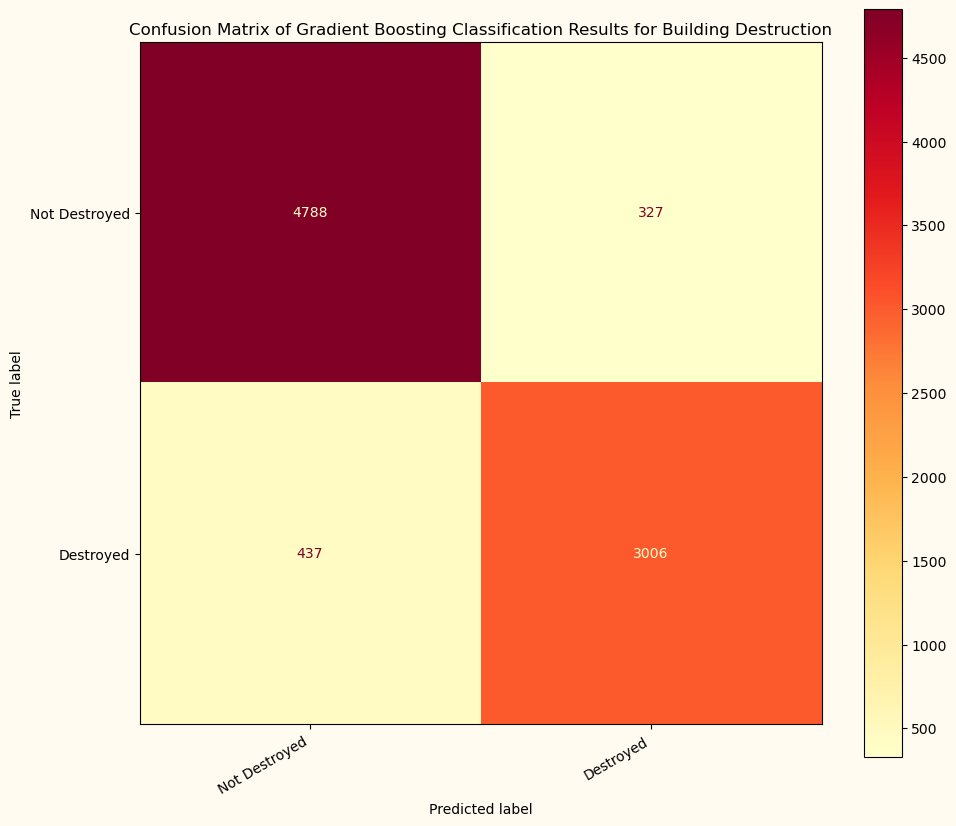

In [96]:
cm = confusion_matrix(y_test, best_gbc.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Destroyed', 'Destroyed'])
fig, ax = plt.subplots(figsize=(11, 11), facecolor = ('#fffbf0'))
disp.plot(ax=ax, cmap='YlOrRd')
fig.autofmt_xdate()
plt.title("Confusion Matrix of Gradient Boosting Classification Results for Building Destruction")
plt.show()


We display feature importances for this model:

In [97]:
from IPython.display import display

# Use impurity-based feature importance (sum across all encodings for each feature)
importances = np.zeros(14)
importances[0] = np.sum(best_gbc.feature_importances_[4:20])
importances[1] = np.sum(best_gbc.feature_importances_[20:26])
importances[2] = np.sum(best_gbc.feature_importances_[26:29])
importances[3] = np.sum(best_gbc.feature_importances_[29:33])
importances[4] = np.sum(best_gbc.feature_importances_[33:41])
importances[5] = np.sum(best_gbc.feature_importances_[41:44])
importances[6] = np.sum(best_gbc.feature_importances_[44:48])
importances[7] = np.sum(best_gbc.feature_importances_[48:52])
importances[8] = np.sum(best_gbc.feature_importances_[52:55])
importances[9] = np.sum(best_gbc.feature_importances_[55:58])
importances[10:,] = best_gbc.feature_importances_[:4]

# Create a new dataframe for feature importances across original feature columns and display it
feature_df = pd.DataFrame({'feature': original_columns[:-1], 'importance': importances})
display(feature_df)


,feature,importance
0,* Structure Type,0.013333
1,* Roof Construction,0.007593
2,* Eaves,0.013224
3,* Vent Screen,0.015156
4,* Exterior Siding,0.041981
5,* Window Pane,0.013961
6,* Deck/Porch On Grade,0.005089
7,* Deck/Porch Elevated,0.004369
8,* Patio Cover/Carport Attached to Structure,0.003246
9,* Fence Attached to Structure,0.011416


For this model, the most important features were latitude and longitude.